# Machine Learning Project: Audio Dog Bark Identification (〃￣︶￣)

The goal of this project is to be able to accurately identify whether a dog has barked either in a given audio file or an feeding microphone. The project may go further as to identify if a dog is in general present in the location of the given audio not just by listening for barks but also for whinning and other sounds that dogs produce. To improve reliability the resulting model may be trained on one breed and size of a dog and can be trained to identify one unique dog amongst others (such as listening for my dog Leo).

A reliable dataset which was found and will be used is from kaggle, provided by the user, mmoreaux. The link to the dataset is https://www.kaggle.com/mmoreaux/audio-cats-and-dogs and contains 113 dog identified audio files (as well as cat identified audio files but those do not pertain to our scope and may be used as a negative train/test set). Each of  the dog audio files contain background noise and multiple dog barks each
The second dataset was provided by my own handy dandy bark maker, Leo, personal dog assistant for this project. It was very easy to get him to bark to provide data for this project with some quality playtime. Although this dataset did not contain as many audiofiles, the files themselves were much longer and contained many more barks than that of the kaggle dataset.

The libraries used within this project are declared by the imports below

In [2]:
import librosa
import librosa.display
import matplotlib
import scipy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

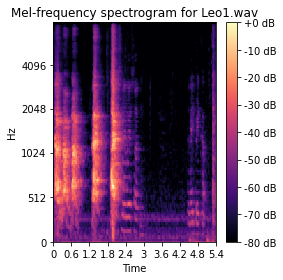

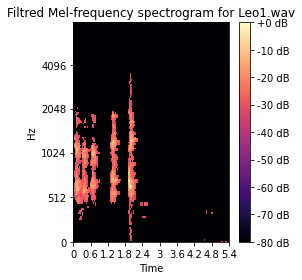

In [13]:
# Display is used to show spectrograms and how they look after they are filtered
# Change Display to show more or none spectrograms 
display = 1
for files in os.listdir("./Leo"):
    # LOADING FILE
    y, sr = librosa.load("./Leo/" + files)

    #Producing spectrogram to be used to event detection and slicing  
    S = librosa.feature.melspectrogram(y, sr=sr)

    # Convert to log scale (dB). We'll use the peak power as reference.
    log_S = librosa.amplitude_to_db(S,ref=np.max)
    S_dB = librosa.power_to_db(S, ref=np.max)

    if display > 0:
        plt.figure(figsize=(4, 4))
        librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sr,fmax=8000)
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel-frequency spectrogram for ' + files)
        plt.tight_layout()
        plt.show()

    # FILTERING
    win = (y.shape[0])/S_dB.shape[1]
    avg = np.sum(S_dB)/(S_dB.shape[0]*S_dB.shape[1])
    S_dB[S_dB < avg+30] = -80
    cols = np.sum(S_dB, axis=0)
    minimum = -(80*128)+500

    if display > 0:
        plt.figure(figsize=(4, 4))
        librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sr,fmax=8000)
        plt.colorbar(format='%+2.0f dB')
        plt.title('Filtred Mel-frequency spectrogram for ' + files)
        plt.tight_layout()
        plt.show()
    display-= 1 

    # ### GROUPING ALGORITHM - Run only once then observe the data to confirm splicing
    # ###
    # ### If need to run grouping again uncomment   
    # tog = 0
    # group = []
    # index = 0
    # grouping = 0
    # for i in cols:
    #     index+= 1
    #     if i > minimum:
    #         tog = 1
    #         group.append(index)
    #     else:
    #         if tog is 1:
    #             if len(group) > 5:
    #                 window = y[int(group[0]*win):int((group[0] + (group[-1]+10 - group[0]))*win)]
    #                 librosa.output.write_wav("./extraction/" + files[0:-4] + "-" + str(grouping) + ".wav", \
    #                                             y[int(group[0]*win):int((group[0] + (group[-1] - group[0]))*win)],sr)
    #                 grouping+= 1
    #             group = []
    #         tog = 0 
    #
    # ### END GROUPING ALGORITHM
    

### (～￣▽￣)～ Display Spectrograms
We may take a quick look at what the spectrograms of our barks look like at this point instead of having to look as spectrograms of long unwanted and noisy audiofiles. We display only a few barks.

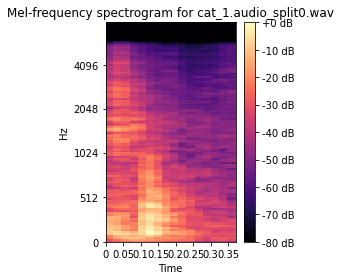

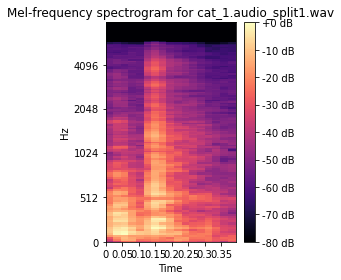

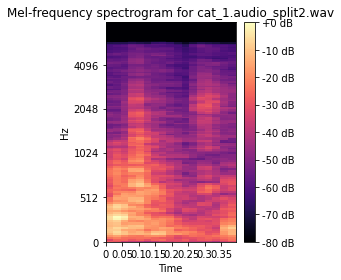

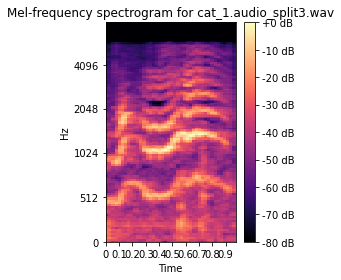

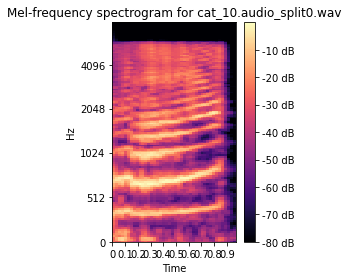

In [10]:
when = 0
for files in os.listdir("./extraction"):
    y, sr = librosa.load("./extraction/" + files)
    S = librosa.feature.melspectrogram(y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)

    #Display Spectrogram
    plt.figure(figsize=(4, 4))
    librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sr,fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram for ' + files)
    plt.tight_layout()
    plt.show()

    # Stop after 5 displays
    when += 1
    if when == 5:
        break

### Convolving spectrograms for dataset organization

We had attempted to convolve the spectrograms and filtered spectrogram column sums array with both a smoothing and edge detecting kernel to see if it would aid in seperating tightly crammed barks for easier extraction but it was unsuccessful. Here is what convolution did to spectrograms and one can observe that it does not improve the grouping algorithm used to extract bark audio. 


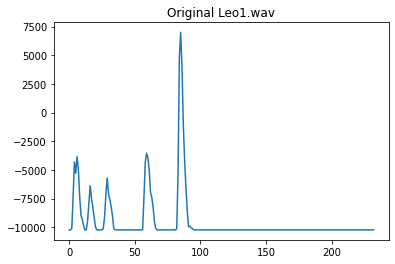

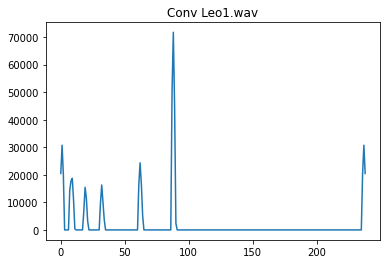

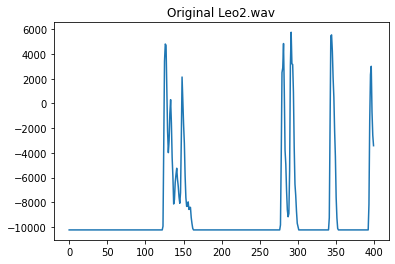

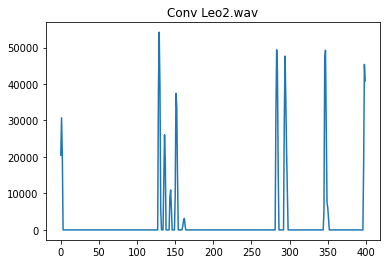

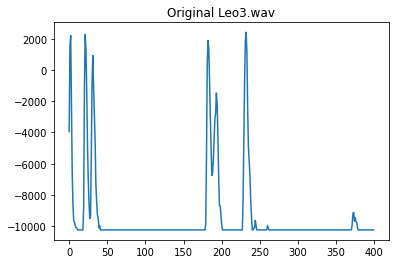

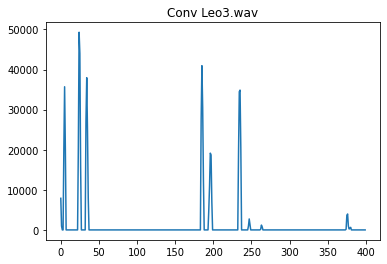

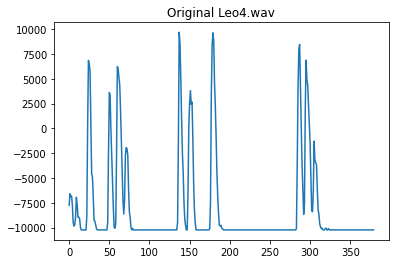

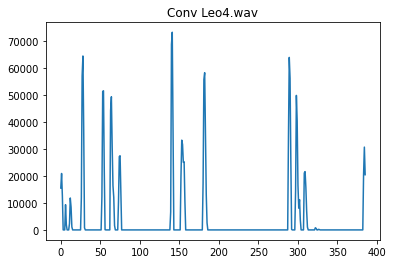

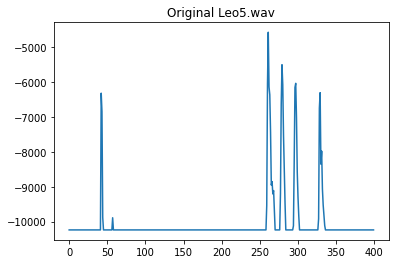

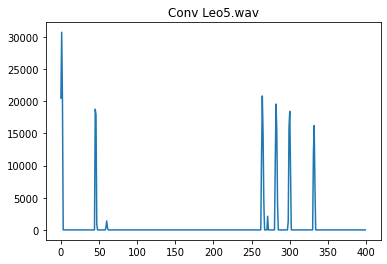

In [83]:
when = 0
for files in os.listdir("./Leo"):
    # LOADING FILE
    y, sr = librosa.load("./Leo/" + files)
    # y, sr = librosa.load("./AudioSet1/Leo1.wav")
    
    # SPECTROGRAM: Let's make and display a mel-scaled power (energy-squared) spectrogram
    S = librosa.feature.melspectrogram(y, sr=sr)
    # FILTERING
    win = (y.shape[0])/S.shape[1]
    avg = np.sum(S)/(S.shape[0]*S.shape[1])
    S[S < avg+30] = -80
    cols = np.sum(S, axis=0)
    minimum = -(80*128)+500
    filter = np.array([-2,-1,1,4,1,-1,-2])
    cols_conv = scipy.signal.convolve(cols[0:400],filter)
    plt.plot(cols[0:400])
    plt.title('Original ' + files)
    plt.show()
    cols_conv[cols_conv < 0] = 0
    plt.plot(cols_conv[0:400])
    plt.title('Conv ' + files)
    plt.show()
    when += 1
    if when == 5:
        break

## Part B: Feature Extraction

Here are a list of features that will be extracted from bark audio time series for production of a model:
* Mel-Spectrogram
* Mel-Spectrogram Cepstrum Coefficients [MFCC]
* Chromagram
* Zero-Crossing Rate
* Root Mean Square [RMS]
* Spectral Centroid 
* Spectral Bandwidth
* Spectral Roll-off Frequency
* Spectral Flatness
* Spectral Contrast

These features are extracted using functions provided by LibROSA



In [184]:
# columns = ['File Name','Mel-Spectrogram','MFCCS','Chromagram','ZCR','RMS','Centroid','Bandwidth','Rolloff','Flatness','Contrast','Class']
columns = ['Class']
df = pd.DataFrame(data = {'File Name': [],'Mel-Spectrogram':[],'MFCCS':[],'Chromagram':[],'ZCR':[],'RMS':[],'Centroid':[],'Bandwidth':[],'Rolloff':[],'Flatness':[],'Contrast':[],'Class':[]})


for files in os.listdir("./extraction"):
    # LOADING FILE
    y, sr = librosa.load("./extraction/" + files)

    #Spectrograms
    stft = librosa.stft(y=y)
    magSpec,phase = librosa.magphase(stft)
    PSpec = magSpec**2

    #Features
    melSpecF = librosa.feature.melspectrogram(S=PSpec,sr=sr)
    mfccsF = librosa.feature.mfcc(S=librosa.power_to_db(melSpec), sr=sr)
    chromaF = librosa.feature.chroma_stft(S=PSpec,sr=sr)
    zcrF = librosa.feature.zero_crossing_rate(y)
    rmsF = librosa.feature.rms(S=magSpec)
    centroidF = librosa.feature.spectral_centroid(S=magSpec)
    bandwidthF = librosa.feature.spectral_bandwidth(S=magSpec)
    rolloffF = librosa.feature.spectral_rolloff(S=magSpec, sr=sr)
    flatnessF = librosa.feature.spectral_flatness(S=magSpec)
    contrastF = librosa.feature.spectral_contrast(S=magSpec, sr=sr)
    df = df.append({'File Name': files,'Mel-Spectrogram':[melSpecF],'MFCCS':[mfccsF],'Chromagram':[chromaF],'ZCR':[zcrF],'RMS':[rmsF],'Centroid':[centroidF],'Bandwidth':[bandwidthF],'Rolloff':[rolloffF],'Flatness':[flatnessF],'Contrast':[contrastF],'Class':[1]},ignore_index=True)
    print(files)

df.to_csv('data.csv',index=False)



cat_1.audio_split0.wav
cat_1.audio_split1.wav
cat_1.audio_split2.wav
cat_1.audio_split3.wav
cat_10.audio_split0.wav
cat_10.audio_split1.wav
cat_10.audio_split2.wav
cat_10.audio_split3.wav
cat_10.audio_split4.wav
cat_10.audio_split5.wav
cat_10.audio_split6.wav
cat_100.audio_split0.wav
cat_101.audio_split0.wav
cat_101.audio_split1.wav
cat_101.audio_split2.wav
cat_102.audio_split0.wav
cat_102.audio_split1.wav
cat_102.audio_split2.wav
cat_102.audio_split3.wav
cat_102.audio_split4.wav
cat_103.audio_split0.wav
cat_103.audio_split1.wav
cat_103.audio_split2.wav
cat_105.audio_split0.wav
cat_105.audio_split1.wav
cat_106.audio_split0.wav
cat_106.audio_split1.wav
cat_106.audio_split2.wav
cat_106.audio_split3.wav
cat_107.audio_split0.wav
cat_107.audio_split1.wav
cat_107.audio_split2.wav
cat_108.audio_split0.wav
cat_109.audio_split0.wav
cat_109.audio_split1.wav
cat_109.audio_split2.wav
cat_11.audio_split0.wav
cat_11.audio_split1.wav
cat_11.audio_split10.wav
cat_11.audio_split11.wav
cat_11.audio_spli

KeyboardInterrupt: 

In [202]:
df = pd.read_csv('./AudioY_-_Sheet1.csv')
a = df.loc[df['file'] == 'dog_barking_86.audio_split0.wav']['isDog'].astype(int)
a

2    1
Name: isDog, dtype: int64

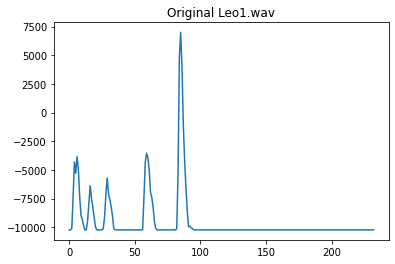

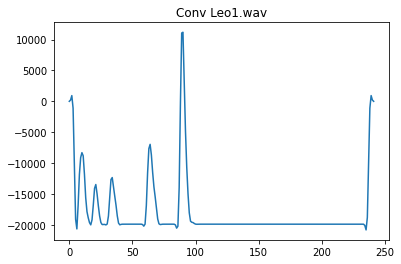

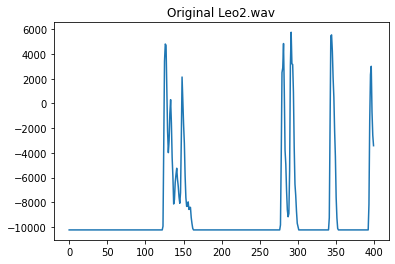

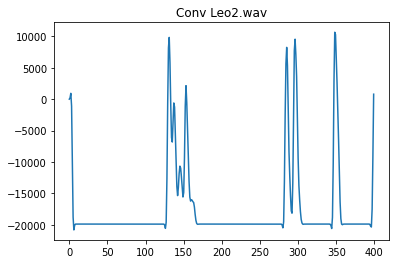

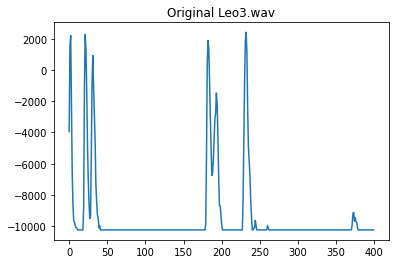

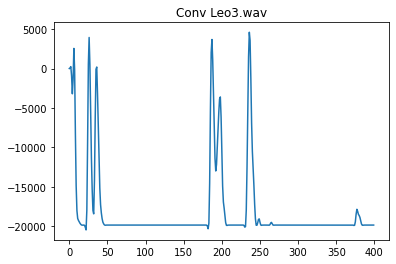

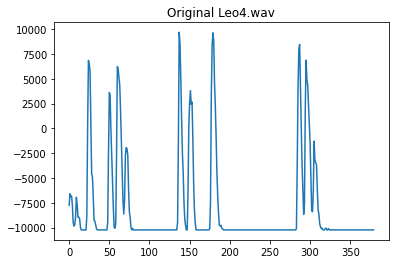

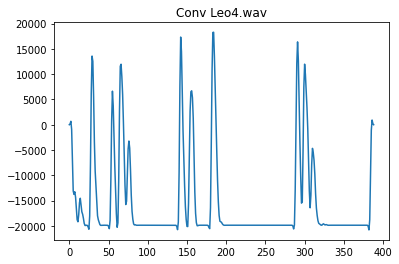

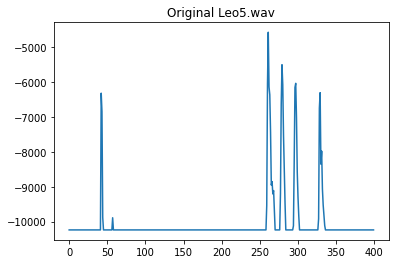

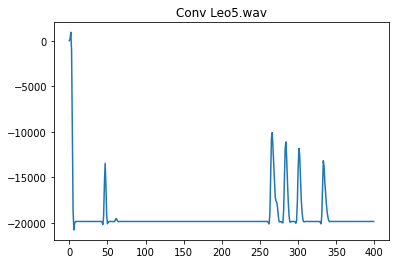

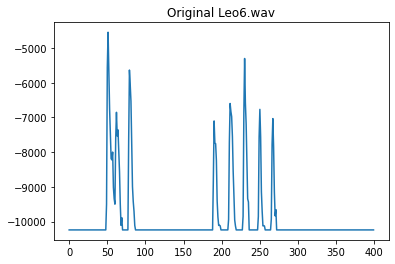

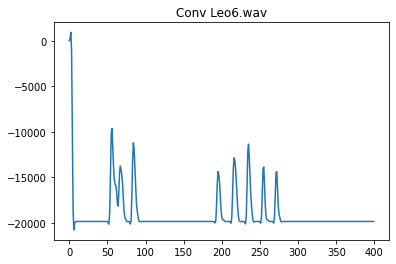

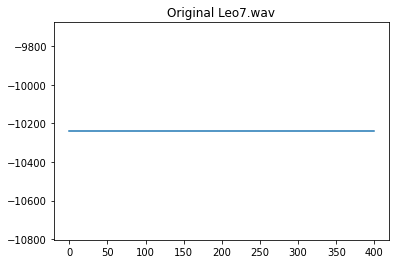

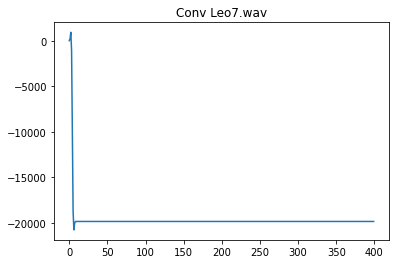

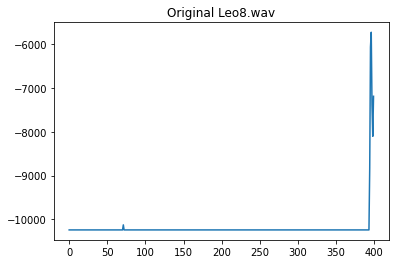

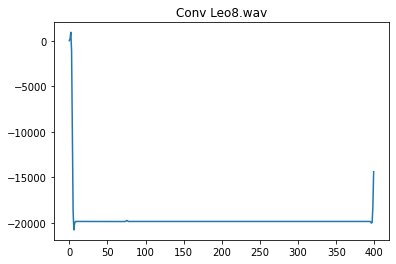

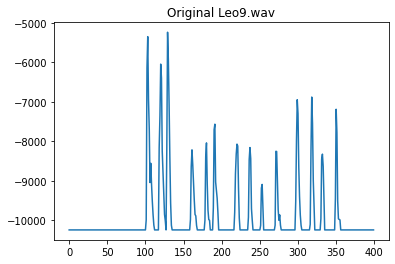

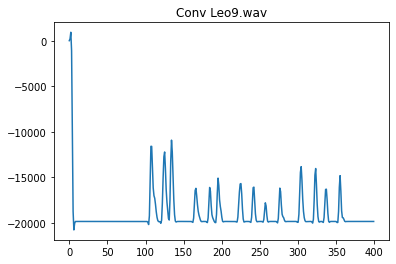

In [68]:
for files in os.listdir("./Leo"):
    # LOADING FILE
    y, sr = librosa.load("./Leo/" + files)
    # y, sr = librosa.load("./AudioSet1/Leo1.wav")
    
    # SPECTROGRAM: Let's make and display a mel-scaled power (energy-squared) spectrogram
    S = librosa.feature.melspectrogram(y, sr=sr)
    
    # Convert to log scale (dB). We'll use the peak power as reference.
   
    # FILTERING
    # print((y.shape[0]/sr)/S_dB.shape[1])
    win = (y.shape[0])/S.shape[1]
    

    avg = np.sum(S)/(S.shape[0]*S.shape[1])
    S[S < avg+30] = -80
    cols = np.sum(S, axis=0)
    minimum = -(80*128)+500
    filter = scipy.signal.flattop(10)
    cols_conv = scipy.signal.convolve(cols[0:400],filter,mode="full")
    plt.plot(cols[0:400])
    plt.title('Original ' + files)
    plt.show()
    plt.plot(cols_conv[0:400])
    plt.title('Conv ' + files)
    plt.show()
    



    # plt.figure(figsize=(10, 4))
    # librosa.display.waveplot(y,sr)
    # plt.title('Original ' + files)
    # plt.tight_layout()
    # plt.show()

    # plt.figure(figsize=(10, 4))
    # librosa.display.waveplot(y_conv,sr)
    # plt.title('Convolved  ' + files)
    # plt.tight_layout()
    # plt.show()
    # librosa.output.write_wav("./convolved/" + files[:-4] + "convolved.wav", y,sr)